# Introduction

### Clustering Buenos Aires Neighborhoods by Quality of Life

This notebook presents the core analytical stage of the project: clustering neighborhoods in Buenos Aires based on their structural, environmental, and socio-economic characteristics.

Our goal is to group similar areas into clusters representing different levels of urban comfort, safety, and infrastructure access, without relying on pre-labeled data. This unsupervised approach allows us to uncover hidden patterns and distinguish distinct neighborhood profiles across the city.

### Objectives
- Reduce dimensionality of the data while preserving its structure and meaning.

- Apply unsupervised learning (PCA + KMeans) to discover natural groupings among the neighborhoods.

- Assign human-readable labels to each cluster (e.g., "Highly comfortable living zone", "Socially challenged green zone").

- Evaluate and visualize the clustering quality using metrics and maps.

### Outcome
This notebook outputs:

- A labeled cluster assignment for each neighborhood,

- Visual tools to understand the characteristics of each cluster,

- A prepared dataset ready for communication, reporting, and interactive mapping.

In [28]:
from scipy.stats import skew
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

## Load the data
 
Let us load the dataset, which we prepared in previous notebook

In [157]:
neighborhood_data = pd.read_csv('../data/Full_ba_neighborhood_data.csv', sep=',')

In [158]:
df = neighborhood_data.copy()

## Feature Engineering: Derived Indicators

To improve comparability across neighborhoods and enable clustering, we derive several normalized indicators based on population or area size. These indicators help quantify crime levels, urban infrastructure, and density.

The features created in this step include:

- `schools_per_1000`: number of public and private schools per 1000 residents  
- `hospitals_per_1000`: number of hospitals per 1000 residents  
- `green_area_per_1000`: green area in square meters per 1000 residents  
- `crime_per_1000`: total number of crimes per 1000 residents (including homicides, injuries, property crimes, and threats)  
- `homicides_crime_per_1000`: homicide rate per 1000 residents  
- `property_crime_per_1000`: property crime rate per 1000 residents  
- `population_density`: number of residents per square kilometer of the neighborhood  
- `slum_density`: number of slum residents per square kilometer  

These features are essential for standardizing the data and preparing for further analysis and clustering.


In [121]:
df['schools_per_1000'] = (df['private_institution'] + df['state_institution']) / df['population'] * 1000
df['hospitals_per_1000'] = df['amount_of_hospitals'] / df['population'] * 1000
df['green_area_per_1000'] = df['total_green_area'] / df['population'] * 1000
df['crime_per_1000'] = (
    df['homicides_crime'] +
    df['injuries_crime'] +
    df['property_crime'] +
    df['threats_crime']
) / df['population'] * 1000

df['homicides_crime_per_1000'] = df['homicides_crime'] / df['population'] * 1000
df['property_crime_per_1000']  = df['property_crime'] / df['population'] * 1000
df['population_density'] = df['population'] / df['area_neib'] 
df['slum_density'] = df['slum'] / df['area_neib'] * 1000 

## Feature Normalization

As the next step we are going to select features for the following learning.

In [130]:
features = [
    'population', 'slum_density', 'amount_of_hospitals', 'station', 'day_noise',
    'night_noise', 'homicides_crime', 'injuries_crime', 'property_crime',
    'threats_crime', 'private_institution', 'state_institution',
    'total_green_area', 'n_green_zones', 'n_green_zones_with_pati',
    'mean_green_area', 'green_area_pct', 'schools_per_1000', 'hospitals_per_1000',
    'green_area_per_1000', 'crime_per_1000', 'homicides_crime_per_1000', 
    'property_crime_per_1000', 'population_density'
]

## Log transformation

Let us understand with which features we want to do a log transformation before scaling. For this puprose we will use skew function from scipy.stats.

In [131]:
def analyze_skewness(df, features, include_maybe = False, plot=False):
    results = []
    features_for_log = []
    for feature in features:
        original = df[feature].dropna()
        logged = np.log1p(original)

        skew_orig = skew(original)
        skew_logged = skew(logged)

        suggestion = "log1p" if skew_orig > 1 else ("maybe" if 0.5 < skew_orig <= 1 else "keep")
        if suggestion == "log1p" or suggestion == "maybe" and include_maybe == True:
            features_for_log.append(feature)

        results.append({
            "feature": feature,
            "skew_original": round(skew_orig, 3),
            "skew_log1p": round(skew_logged, 3),
            "suggestion": suggestion
        })

        if plot:
            fig, axs = plt.subplots(1, 2, figsize=(10, 4))
            sns.histplot(original, bins=30, ax=axs[0], kde=True)
            axs[0].set_title(f"{feature} (original)")

            sns.histplot(logged, bins=30, ax=axs[1], kde=True)
            axs[1].set_title(f"{feature} (log1p)")
            plt.tight_layout()
            plt.show()

    return pd.DataFrame(results), features_for_log

In [132]:
data_features, features_for_log = analyze_skewness(df, features, include_maybe = True)
data_features

,feature,skew_original,skew_log1p,suggestion
0,population,1.576,-0.023,log1p
1,slum_density,2.352,2.352,log1p
2,amount_of_hospitals,2.391,1.249,log1p
3,station,1.712,0.818,log1p
4,day_noise,1.888,0.718,log1p
5,night_noise,-0.666,-1.578,keep
6,homicides_crime,-0.887,-1.474,keep
7,injuries_crime,1.360,0.126,log1p
8,property_crime,1.909,-0.074,log1p
9,threats_crime,1.479,-0.000,log1p


In [133]:
df_scaled = df.copy()
for feature in features_for_log:
    df_scaled[feature] = np.log1p(df[feature])

## Feature Scaling

To ensure fair comparison between features with different units and scales, we apply **standardization** using `StandardScaler` from `sklearn`. This method transforms each feature to have a mean of 0 and a standard deviation of 1, which is especially important before performing dimensionality reduction (e.g., PCA) or clustering (e.g., KMeans).


In [134]:
scaler = StandardScaler()

df_scaled[features] = scaler.fit_transform(df_scaled[features])

In [135]:
X = df_scaled[features].copy()

<Axes: xlabel='green_area_pct', ylabel='Count'>

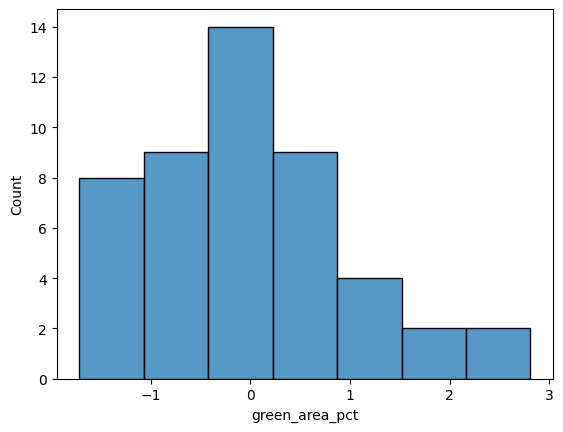

In [136]:
sns.histplot(data=X, x = 'green_area_pct')

## Feature Selection

### 1. Correlation Matrix

We begin feature selection by computing the **correlation matrix**, which shows pairwise Pearson correlation coefficients between all standardized features. This allows us to:

- Identify multicollinearity — features that are strongly correlated (e.g., > 0.9).
- Reduce redundancy by removing highly correlated variables that provide similar information.
- Inform further dimensionality reduction techniques like PCA.

The table below presents the correlation coefficients between all selected features.


In [137]:
X.corr()

,population,slum_density,amount_of_hospitals,station,day_noise,night_noise,homicides_crime,injuries_crime,property_crime,threats_crime,...,n_green_zones_with_pati,mean_green_area,green_area_pct,schools_per_1000,hospitals_per_1000,green_area_per_1000,crime_per_1000,homicides_crime_per_1000,property_crime_per_1000,population_density
population,1.000000,0.092539,0.394717,0.503411,-0.076260,0.156233,0.400679,0.790590,0.903420,0.824733,...,0.619070,0.050625,-0.004813,-0.174491,-0.029405,-0.177158,-0.093955,-0.556977,-0.058033,0.612537
slum_density,0.092539,1.000000,-0.039505,-0.119855,-0.272016,-0.185958,0.452692,0.330572,0.154598,0.353570,...,0.366573,0.246225,0.446358,0.116205,-0.061107,0.434324,0.218164,0.175535,0.144234,-0.293565
amount_of_hospitals,0.394717,-0.039505,1.000000,0.219502,-0.169646,-0.133909,0.174454,0.367792,0.316856,0.385406,...,0.275649,0.158250,-0.001616,0.028072,0.796529,-0.022068,-0.100613,-0.185377,-0.122214,0.208781
station,0.503411,-0.119855,0.219502,1.000000,-0.143551,0.080755,0.320517,0.562993,0.643746,0.475999,...,0.105898,-0.045901,-0.068152,0.134303,-0.040435,-0.176235,0.360952,-0.167947,0.417165,0.630385
day_noise,-0.076260,-0.272016,-0.169646,-0.143551,1.000000,0.749186,-0.409472,-0.193011,-0.154283,-0.189151,...,-0.089717,-0.106256,-0.257300,-0.179774,-0.117453,-0.239597,-0.214617,-0.353394,-0.192511,0.145419
night_noise,0.156233,-0.185958,-0.133909,0.080755,0.749186,1.000000,-0.047963,0.083421,0.121655,0.031275,...,0.064642,-0.186063,-0.233144,-0.213973,-0.153717,-0.278510,-0.082318,-0.390953,-0.050490,0.311042
homicides_crime,0.400679,0.452692,0.174454,0.320517,-0.409472,-0.047963,1.000000,0.584932,0.514830,0.581688,...,0.609502,0.253397,0.343221,0.086806,-0.030828,0.327415,0.354737,0.347226,0.322203,0.099889
injuries_crime,0.790590,0.330572,0.367792,0.562993,-0.193011,0.083421,0.584932,1.000000,0.920205,0.973203,...,0.646755,0.158040,0.227452,0.234256,0.021119,0.101330,0.445395,-0.300201,0.426111,0.402850
property_crime,0.903420,0.154598,0.316856,0.643746,-0.154283,0.121655,0.514830,0.920205,1.000000,0.910935,...,0.622537,0.117123,0.142332,0.136649,-0.089901,-0.020016,0.337661,-0.391602,0.374926,0.548158
threats_crime,0.824733,0.353570,0.385406,0.475999,-0.189151,0.031275,0.581688,0.973203,0.910935,1.000000,...,0.693163,0.152536,0.204782,0.179965,0.038578,0.084590,0.357464,-0.308293,0.332738,0.375803


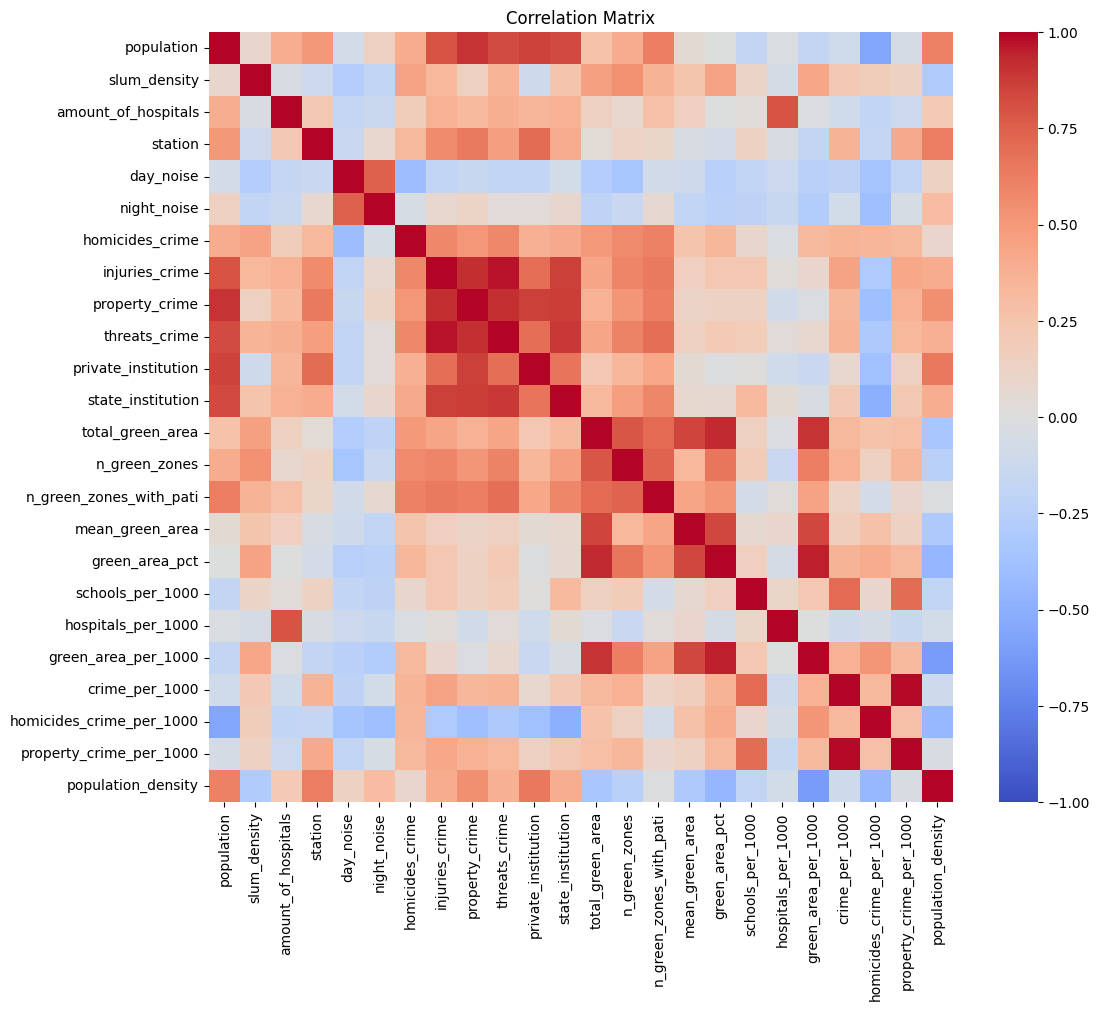

In [138]:

plt.figure(figsize=(12,10))
corr = X.corr()
sns.heatmap(corr, annot=False, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation Matrix")
plt.show()

### 2. Removing Highly Correlated Features
We will now drop one feature from each highly correlated pair (threshold > 0.9) to avoid redundancy.


In [139]:
features_to_drop_visually = ['population', 'total_green_area']
X = X.drop(columns=features_to_drop_visually)

In [140]:
def drop_highly_correlated_features(df, threshold=0.9):
    corr_matrix = df.corr().abs()
    # We take the upper triangular part to avoid duplicates
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    # List of features to remove
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

    return df.drop(columns=to_drop), to_drop

In [141]:
X_clean, features_to_drop = drop_highly_correlated_features(X, threshold=0.9)

<Axes: >

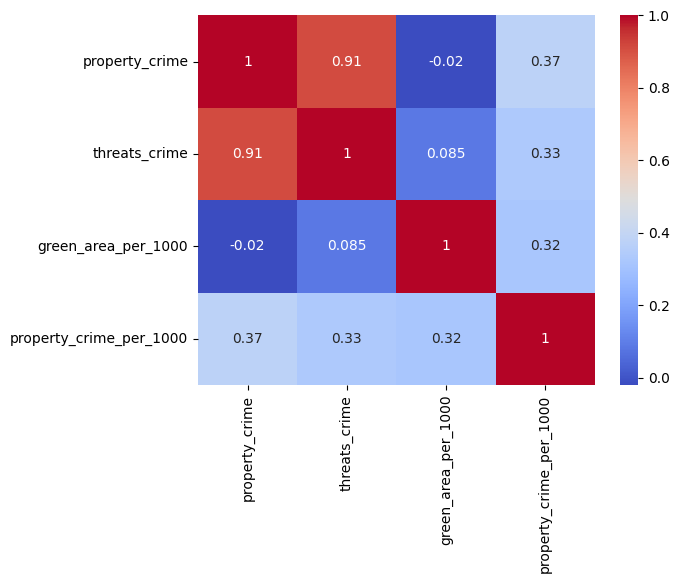

In [159]:
sns.heatmap(df_scaled[features_to_drop].corr(), annot=True, cmap='coolwarm')

## Principal Component Analysis (PCA)

In this section, we apply **Principal Component Analysis (PCA)** to reduce the dimensionality of our dataset.

PCA helps us:
- Remove collinearity and reduce redundancy between features,
- Project data into a lower-dimensional space while preserving the most variance,
- Improve clustering and visualization performance.

Below, we calculate the cumulative proportion of explained variance by each principal component. We will select the number of components that explain at least 95% of the total variance in the dataset.


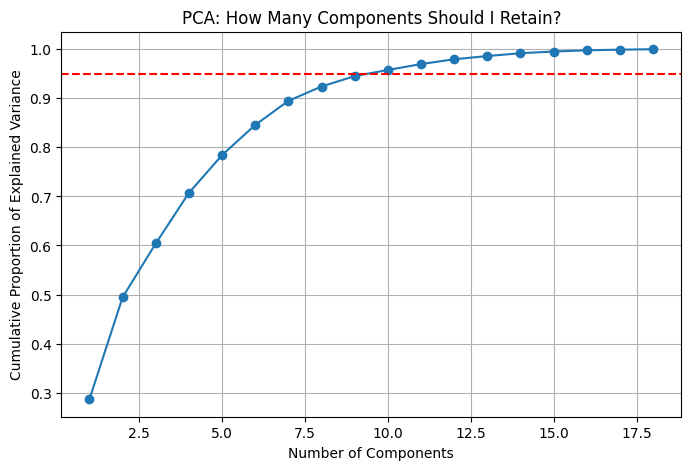

In [164]:
from sklearn.decomposition import PCA

pca = PCA(n_components=len(X_clean.columns))
X_pca = pca.fit_transform(X_clean)

explained_var = pca.explained_variance_ratio_

# Cumulative proportion of explained variance
cumulative_var = explained_var.cumsum()

plt.figure(figsize=(8,5))
plt.plot(range(1, len(explained_var)+1), cumulative_var, marker='o')
plt.axhline(y=0.95, color='red', linestyle='--')
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Proportion of Explained Variance")
plt.title("PCA: How Many Components Should I Retain?")
plt.grid(True)
plt.show()

### Feature Contribution to Principal Components via PCA Loadings

After applying PCA, we analyze which original features contribute the most to the principal components.

PCA loadings represent the weight of each original feature in each principal component. High absolute values indicate stronger influence.

The heatmap below helps us understand which features are most important in forming the main components used for clustering and further analysis.

In [160]:
loadings = pd.DataFrame(
    pca.components_.T,
    columns=[f'PC{i+1}' for i in range(len(X_clean.columns))],
    index=X_clean.columns
)

Heat map for feature contribution to principal components. Each cell is a contribution of a feature to a component.

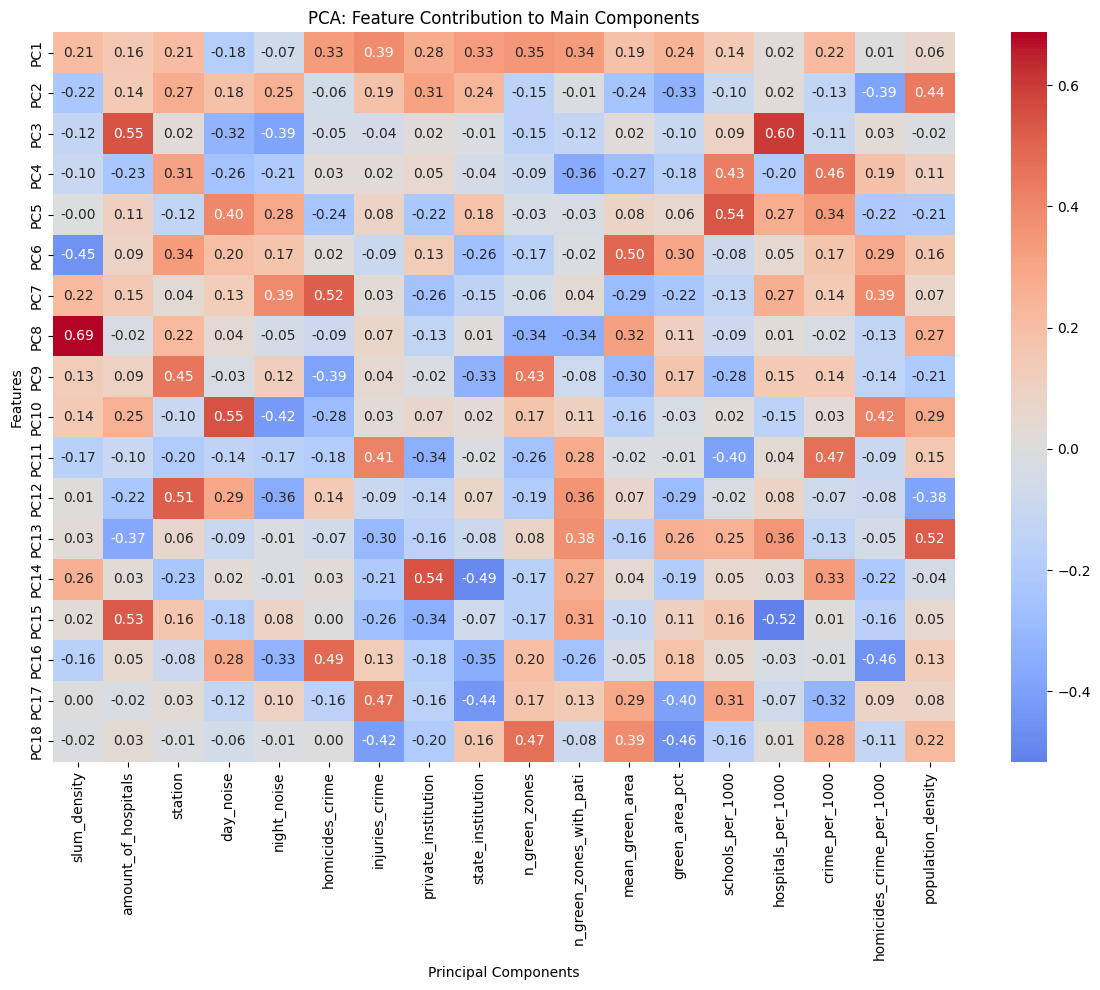

In [166]:
plt.figure(figsize=(12, 10))
sns.heatmap(loadings.T, cmap='coolwarm', center=0, annot=True, fmt=".2f")
plt.title("PCA: Feature Contribution to Main Components")
plt.ylabel("Features")
plt.xlabel("Principal Components")
plt.tight_layout()
plt.show()

### Selecting the Number of Components
We will choose the smallest number of principal components that together explain ≥ 95% of the total variance (shown by the red dashed line). 
As we could see, the number of components is 10.


In [147]:
pca_10 = PCA(n_components=10)
X_pca_10 = pca_10.fit_transform(X_clean)

In [148]:
df_pca = pd.DataFrame(
    X_pca_10,
    columns=[f'PC{i+1}' for i in range(X_pca_10.shape[1])]
)

df_pca['neighborhood'] = df['neighborhood'].values
df_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,neighborhood
0,-4.081867,-0.664407,1.289342,2.200154,0.025156,-2.254037,-1.824809,-0.021997,0.314820,-0.374363,AGRONOMIA
1,0.753140,3.612481,0.818300,1.493782,-1.510131,-0.097193,0.104068,0.579739,-0.891048,0.523675,ALMAGRO
2,2.441558,3.411162,0.708252,2.106574,-0.889644,0.905265,0.085845,1.061663,-1.225691,0.132116,BALVANERA
3,3.394041,0.305492,2.053399,-1.733288,1.413930,-1.135432,1.904449,-0.492344,-0.049130,0.231237,BARRACAS
4,1.902653,0.210091,0.379590,-1.333870,-1.336110,1.093926,-1.786131,-0.151977,0.242124,-0.151698,BELGRANO


## Determining the Optimal Number of Clusters (Elbow & Silhouette Method)

To determine the most appropriate number of clusters for KMeans clustering, we use both the **Elbow Method** and the **Silhouette Method**.  
These techniques help identify the point where increasing the number of clusters no longer significantly improves clustering quality.

- **Elbow Method**: We analyze the inertia (sum of squared errors) to find the "elbow" point — the value of *k* after which inertia decreases more slowly.
- **Silhouette Method**: We calculate the silhouette score for each *k* — a metric that measures how well each object lies within its cluster. A higher score indicates better-defined clusters.

By combining insights from both methods, we aim to choose a *k* that balances compactness and separation.

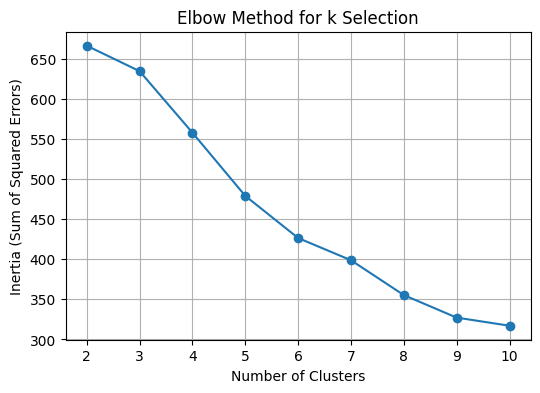

In [165]:
from sklearn.cluster import KMeans

inertia = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_pca_10) 
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(6,4))
plt.plot(K_range, inertia, marker='o')
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia (Sum of Squared Errors)")
plt.title("Elbow Method for k Selection")
plt.grid(True)
plt.show()

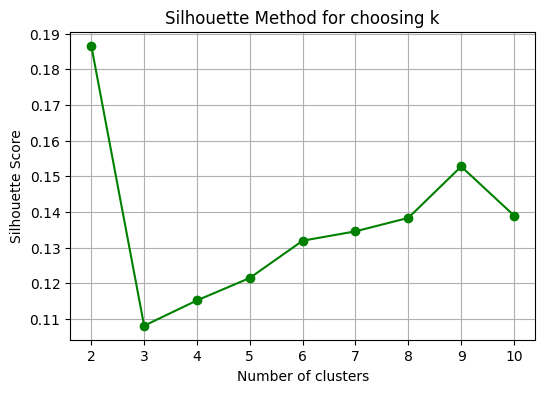

In [161]:
from sklearn.metrics import silhouette_score

silhouette_scores = []

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_pca_10)
    score = silhouette_score(X_pca_10, labels)
    silhouette_scores.append(score)

plt.figure(figsize=(6,4))
plt.plot(range(2, 11), silhouette_scores, marker='o', color='green')
plt.xlabel("Number of clusters")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Method for Choosing k")
plt.grid(True)
plt.show()

## Final Clustering with k=6

Based on the analysis of the Elbow and Silhouette methods, we decided to use **k = 6** as the optimal number of clusters for KMeans.

In this step, we apply KMeans with k=6, assign cluster labels to each neighborhood, and compute the mean value of features within each cluster.  
This summary will help us characterize and interpret the clusters in terms of socioeconomic, environmental, and infrastructural conditions.


In [151]:
from sklearn.cluster import KMeans

k = 6
kmeans = KMeans(n_clusters=k, random_state=42)
df_pca['cluster'] = kmeans.fit_predict(X_pca_10)

In [152]:
df_clustered = df_scaled.copy()
df_clustered['cluster'] = df_pca['cluster'].values
X_clustered = X_clean.copy()
X_clustered['cluster'] = df_pca['cluster'].values

In order to generalize and highlight key traits of each cluster, we compute and visualize the mean values of all features per cluster.

In [162]:
cluster_summary = X_clustered.groupby('cluster').mean().round(2)

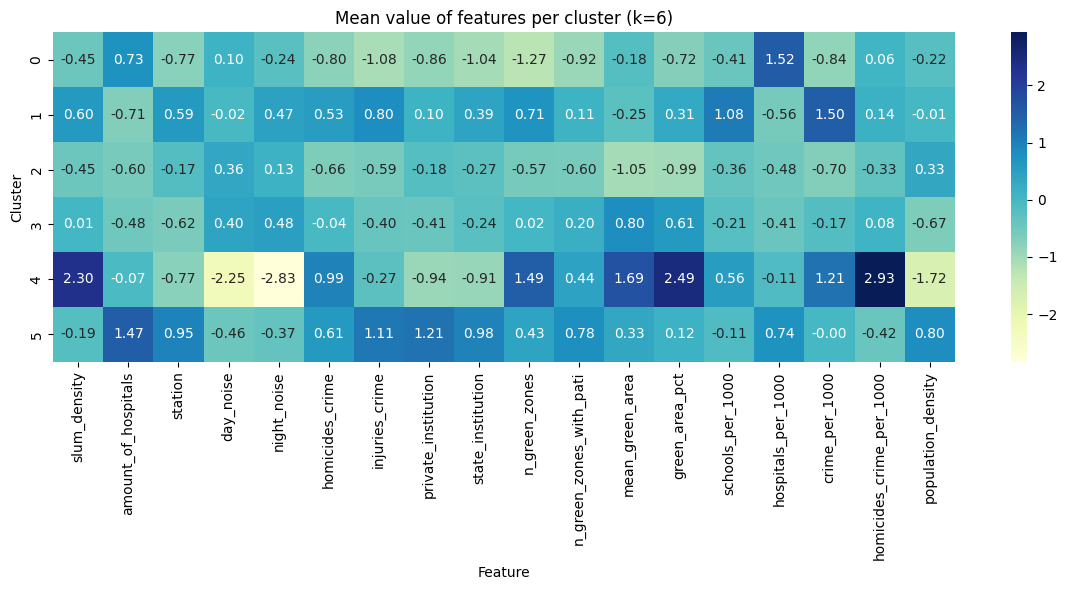

In [155]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.heatmap(cluster_summary, annot=True, cmap='YlGnBu', fmt=".2f")
plt.title("Mean value of features per cluster (k=6)")
plt.xlabel("Feature")
plt.ylabel("Cluster")
plt.tight_layout()
plt.show()

In [156]:
# Load the final version of the data into a csv file

df_clustered.to_csv('../data/Full_data_clustered.csv', index=False)
X_clustered.to_csv('../data/Clean_feature_clustered.csv', index=False)

## Conclusion

In this notebook, we performed clustering of Buenos Aires neighborhoods using PCA-transformed socioeconomic and environmental features.
Key steps included:

- Standardization and dimensionality reduction with PCA,

- Selecting the optimal number of clusters using the Elbow and Silhouette methods,

- Applying KMeans clustering with 6 clusters,

- Analyzing and interpreting clusters using heatmaps of feature averages.

This clustering serves as a foundation for further interpretation and visualization of urban zones — for instance, grouping areas by comfort, infrastructure, or social challenges.

In the next step, we will assign semantic labels to the clusters and create interactive maps to visually communicate these findings.